In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd
from xhistogram.xarray import histogram
from xmitgcm import llcreader
import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5860778.datarmor0/parcels-502090/libparcels_random_ad27fd34-faeb-455c-934a-f18ef3fd7cf8.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=12)

client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.38:37582 Dashboard: http://10.148.0.38:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Lagrangian spectra

In [4]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [5]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_uv_T60_mean0').persist()
#df_Lspectra_mean1 = p.load_diagnostic('spectra_uv_T60_mean1').persist()
#df_Lspectra_mean2 = p.load_diagnostic('spectra_uv_T60_mean2').persist()

In [7]:
bathy = ut.load_bathy(15)

In [8]:
import dask.dataframe as dd
_df = df_Lspectra_mean0[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean0 = df_Lspectra_mean0.merge(ddf).persist()

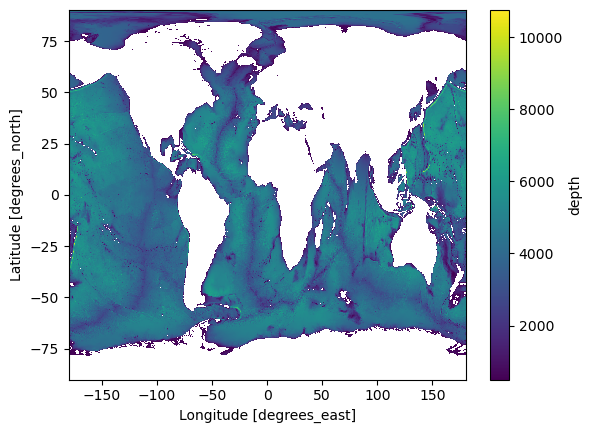

In [15]:
bathy.where(bathy>500).plot()

In [8]:
_df = df_Lspectra_mean1[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean1 = df_Lspectra_mean1.merge(ddf).persist()

In [9]:
_df = df_Lspectra_mean2[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean2 = df_Lspectra_mean2.merge(ddf).persist()

In [9]:
df_Lspectra_mean0 = df_Lspectra_mean0[df_Lspectra_mean0['h']>500]
#df_Lspectra_mean1 = df_Lspectra_mean1[df_Lspectra_mean1['h']>500]
#df_Lspectra_mean2 = df_Lspectra_mean2[df_Lspectra_mean2['h']>500]

### Eulerian spectra

In [10]:
sub = 2
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_SSUV_T60.zarr'))
ds_E = ds_E.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 540, j: 540)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(11, 540, 540), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(11, 540, 540), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(11, 540, 540), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (face, j, i) bool dask.array<chunksize=(11, 540, 540), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 108, 1440), meta=np.ndarray>


In [12]:
ds_E_nomean = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_SSUV_T60_nomean.zarr'))
ds_E_nomean = ds_E_nomean.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E_nomean = ds_E_nomean.where(ds_E_nomean.Depth>500, drop=False)

In [13]:
ds_E_nomean = ds_E_nomean.rename({'SSUV':'SSUV_nomean'})
ds_E = xr.merge([ds_E,ds_E_nomean])

### Global spectra : 

In [11]:
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-70., 70., dl)

#### Lagrangian spectra binning

In [12]:
for ds_Lspectra in [df_Lspectra_mean0]:#,df_Lspectra_mean1,df_Lspectra_mean2]:
    ds_Lspectra['lon'] = (ds_Lspectra['lon']+180)%360 - 180
    ds_Lspectra['lon_cut'] = ds_Lspectra['lon'].map_partitions(pd.cut, lon)
    ds_Lspectra['lat_cut'] = ds_Lspectra['lat'].map_partitions(pd.cut, lat)
    ds_Lspectra = ds_Lspectra.persist()

In [13]:
# Binning and averaging
uv_mean0 = df_Lspectra_mean0.groupby(['lat_cut']).mean().compute()
#uv_mean1 = df_Lspectra_mean1.groupby(['lat_cut']).mean().compute()
#uv_mean2 = df_Lspectra_mean2.groupby(['lat_cut']).mean().compute()

In [14]:
uv_mean0=uv_mean0.drop(columns=['h'])
#uv_mean1=uv_mean1.drop(columns=['h'])
#uv_mean2=uv_mean2.drop(columns=['h'])

In [15]:
_ds = pd.melt(uv_mean0.set_index(uv_mean0.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
               ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()

In [20]:
_ds = pd.melt(uv_mean1.set_index(uv_mean1.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean1'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean1'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean1

In [21]:
_ds = pd.melt(uv_mean2.set_index(uv_mean2.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean2'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean2'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean2

#### Eulerian spectra binning

In [16]:
ds_E['lat'] = 0*ds_E.face+ds_E.YC
ds_E['lat4'] = 0*ds_E.SSUV+ds_E.YC
ds_E = ds_E.persist()

In [17]:
grid = ut.load_grd()#xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds_E = xr.merge([ds_E,grid])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/array/core.py:4311: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.spli

In [18]:
N = histogram(ds_E.lat, bins=[lat], 
              dim=['i', 'j', 'face']
             ).persist()

In [19]:
E = histogram(ds_E.lat4.rename('lat'), bins=[lat], 
              weights=ds_E.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()

In [30]:
E

<xarray.DataArray 'E_SSUV' (freq_time: 1440, lat_bin: 139)>
dask.array<truediv, shape=(1440, 139), dtype=float64, chunksize=(1440, 139), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bin    (lat_bin) float64 -69.5 -68.5 -67.5 -66.5 ... 65.5 66.5 67.5 68.5

In [26]:
E_nomean = histogram(ds_E.lat4.rename('lat'), bins=[lat], 
              weights=ds_E.SSUV_nomean, 
              dim=['i', 'j', 'face']
             )

E_nomean = (E_nomean/N).rename('E_SSUV').persist()

distributed.core - ERROR - 'tcp://10.148.0.74:50626'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 573, in handle_stream
    handler(**merge(extra, msg))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 5018, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.148.0.74:50626'
distributed.utils - ERROR - 'tcp://10.148.0.74:50626'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/utils.py", line 668, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 4032, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/schedule

#### Plot

In [58]:
ds = ds.sortby('frequency')

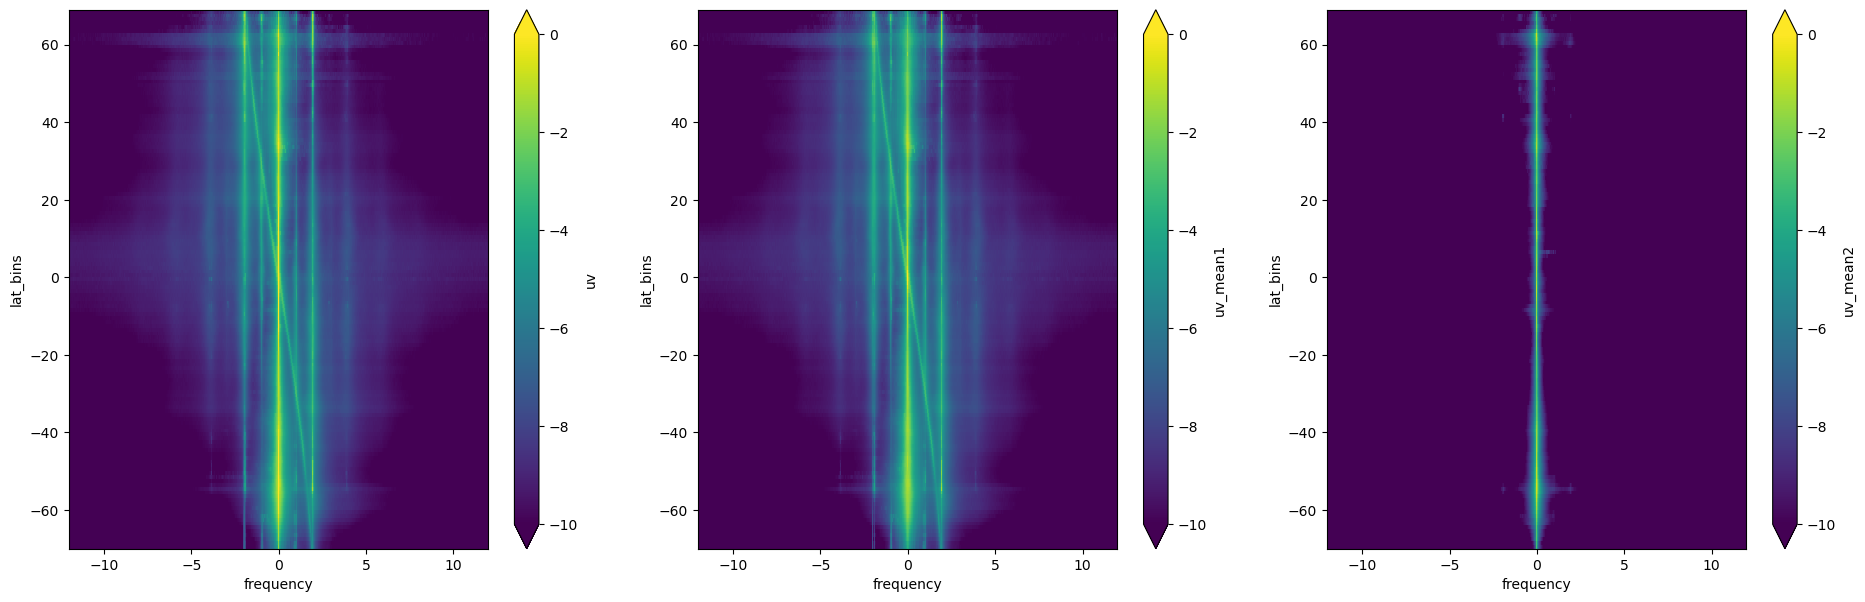

In [59]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log(ds[V]).plot(ax=ax,cmap='viridis',vmax=0,vmin=-10)

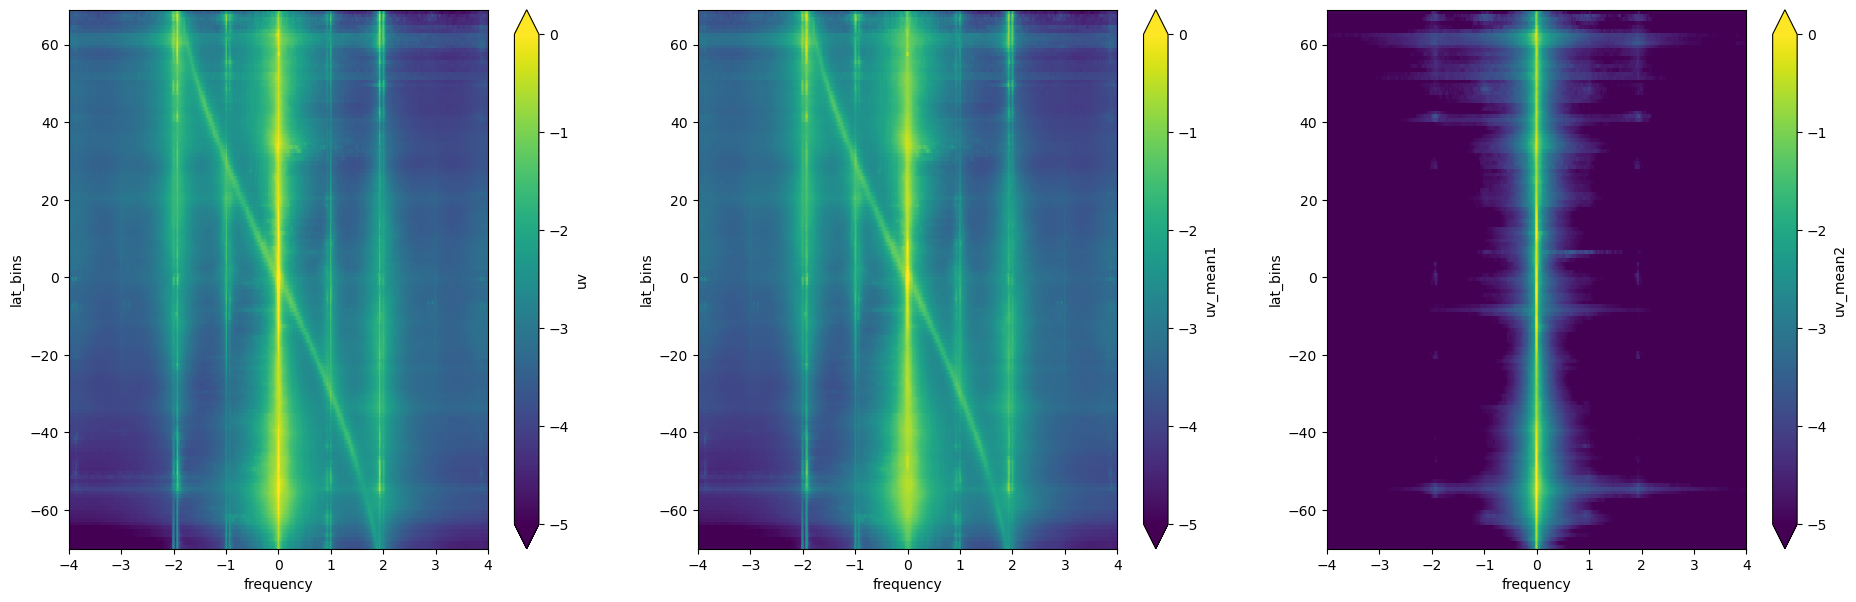

In [60]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log10(ds[V]).plot(ax=ax,cmap='viridis',vmax=0,vmin=-5)
    ax.set_xlim(-4,4)

(-5.0, 5.0)

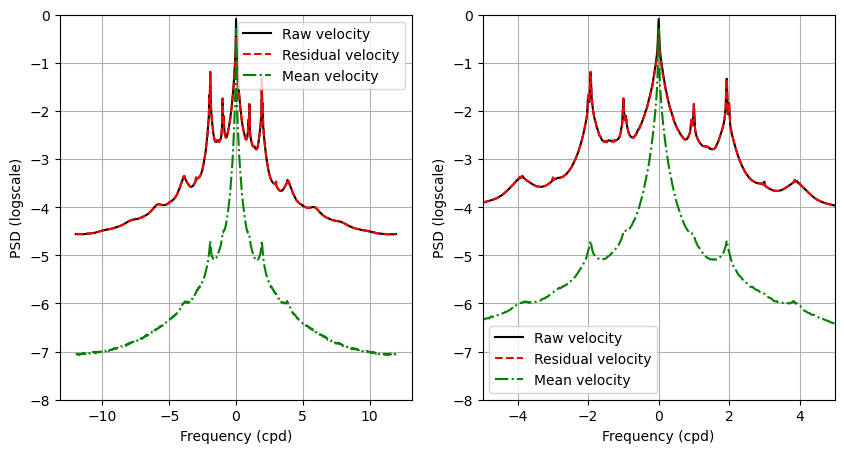

In [78]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds.keys(),colors,styles):
    np.log10(ds[V].mean(['lat_bins'])).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds[V].mean(['lat_bins'])).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

### Plot Eulérien

In [31]:
E = E.rename({'freq_time': 'frequency','lat_bin': 'lat_bins'})
#E_nomean = E_nomean.rename({'freq_time': 'frequency','lat_bin': 'lat_bins'})

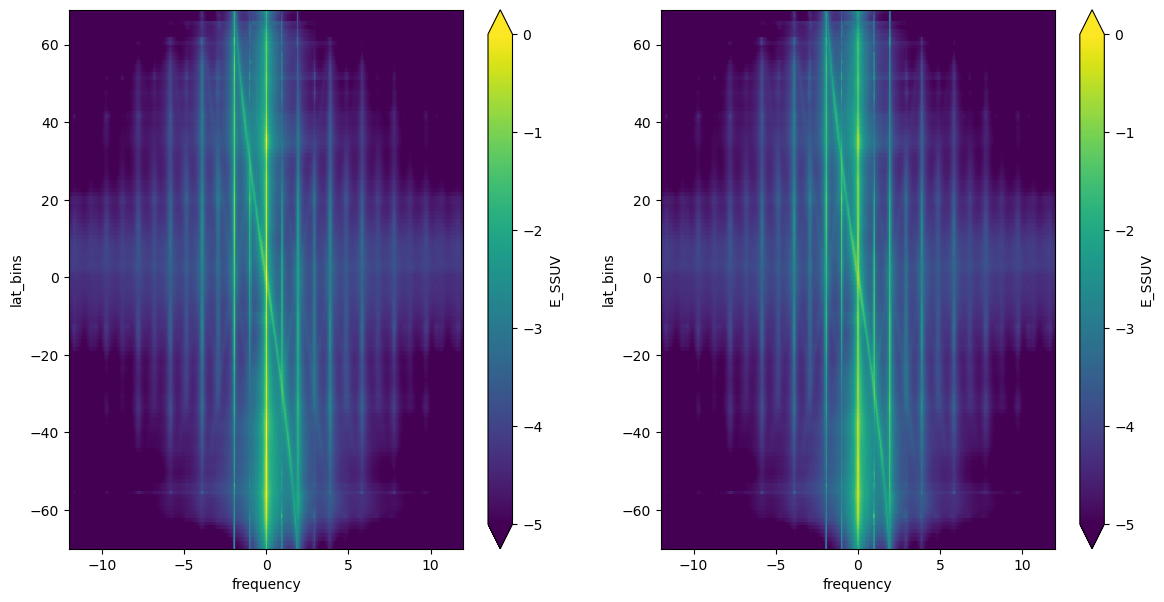

In [84]:
fig,axs = plt.subplots(1,2,figsize=(14,7))
for V,ax in zip([E,E_nomean],axs):
    np.log10(V).plot(ax=ax,cmap='viridis',vmax=0,vmin=-5,y='lat_bins')

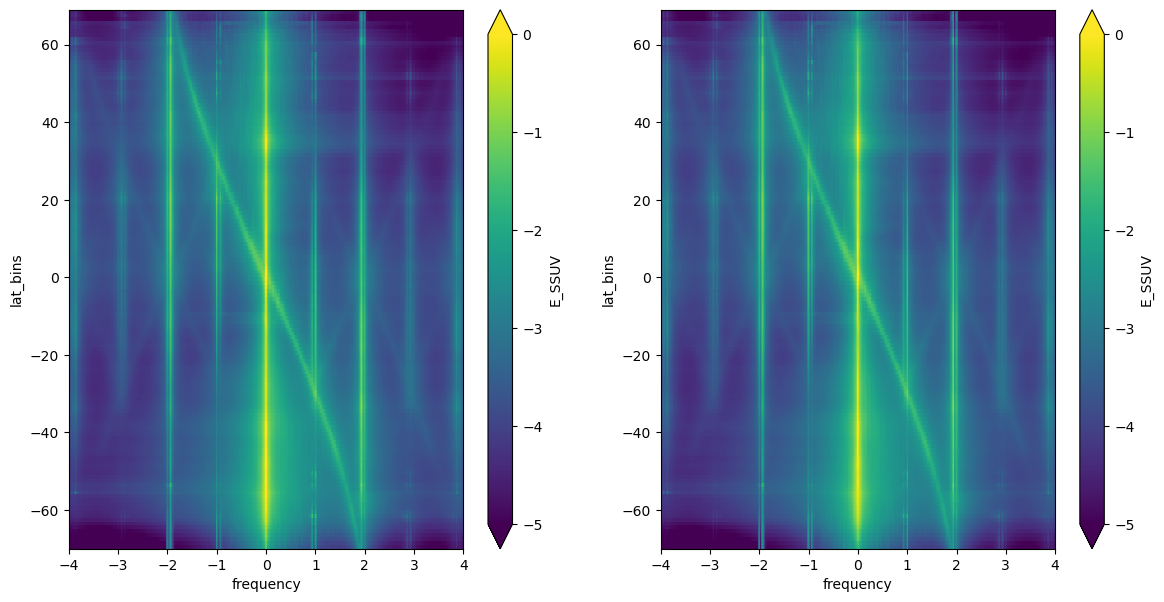

In [81]:
fig,axs = plt.subplots(1,2,figsize=(14,7))
for V,ax in zip([E,E_nomean],axs):
    np.log10(V).plot(ax=ax,cmap='viridis',vmax=0,vmin=-5,y='lat_bins')
    ax.set_xlim(-4,4)

(-5.0, 5.0)

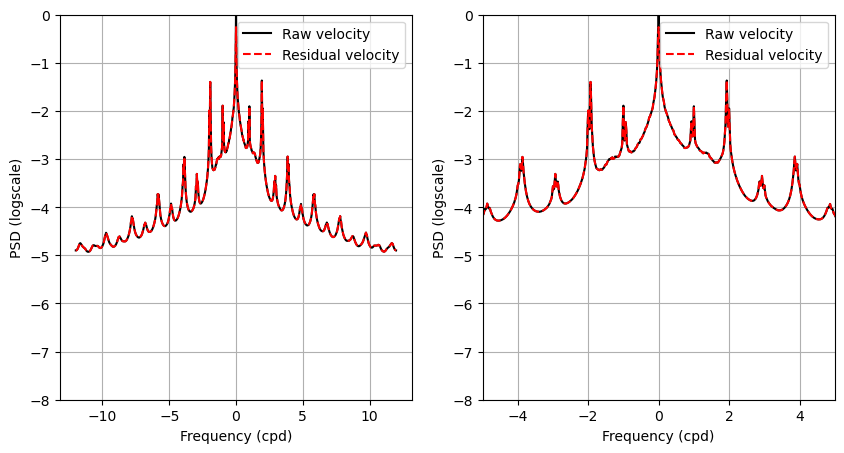

In [79]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip([E,E_nomean],colors,styles):
    np.log10(V.mean(['lat_bins'])).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(V.mean(['lat_bins'])).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Plot Eulérien/Lagrangien (total)

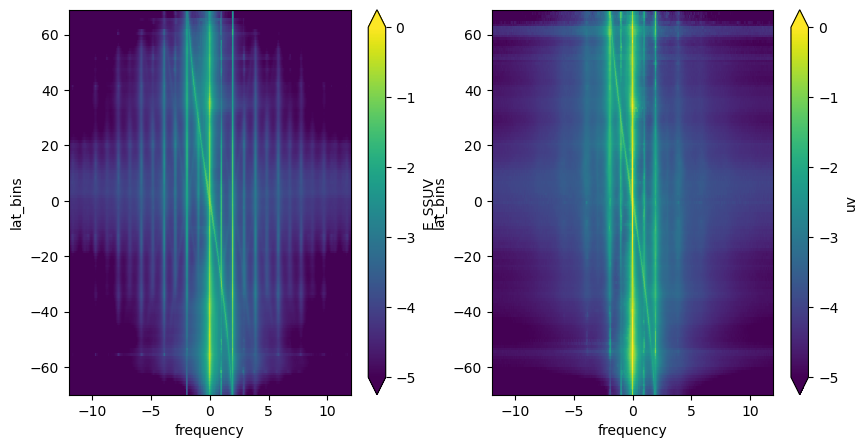

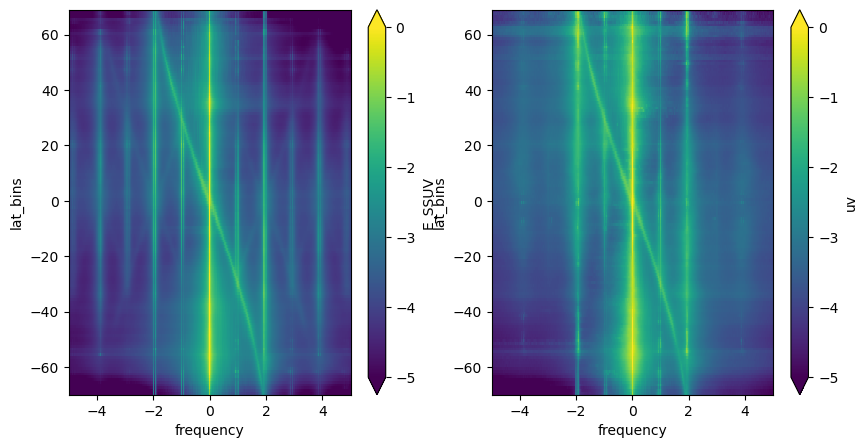

In [64]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
np.log10(E).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[0])
np.log10(ds['uv']).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[1])

fig,axs = plt.subplots(1,2,figsize=(10,5))
np.log10(E).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[0])
np.log10(ds['uv']).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[1])
for ax in axs:
    ax.set_xlim(-5,5)

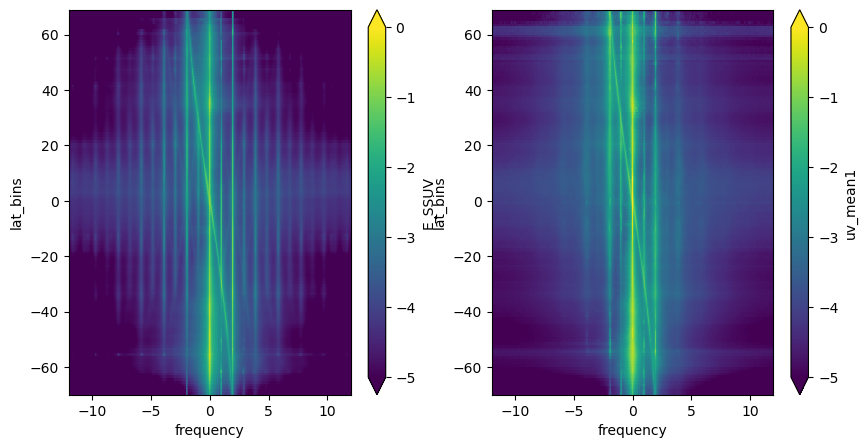

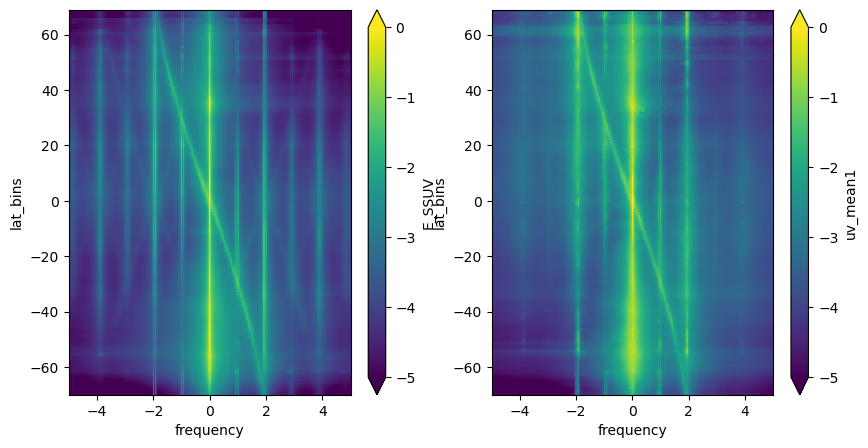

In [69]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
np.log10(E_nomean).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[0])
np.log10(ds['uv_mean1']).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[1])

fig,axs = plt.subplots(1,2,figsize=(10,5))
np.log10(E_nomean).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[0])
np.log10(ds['uv_mean1']).plot(x='frequency', cmap='viridis', vmax=0,vmin=-5,ax=axs[1])
for ax in axs:
    ax.set_xlim(-5,5)

MemoryError: Unable to allocate 1.78 GiB for an array with shape (192, 1, 864, 1440) and data type float64

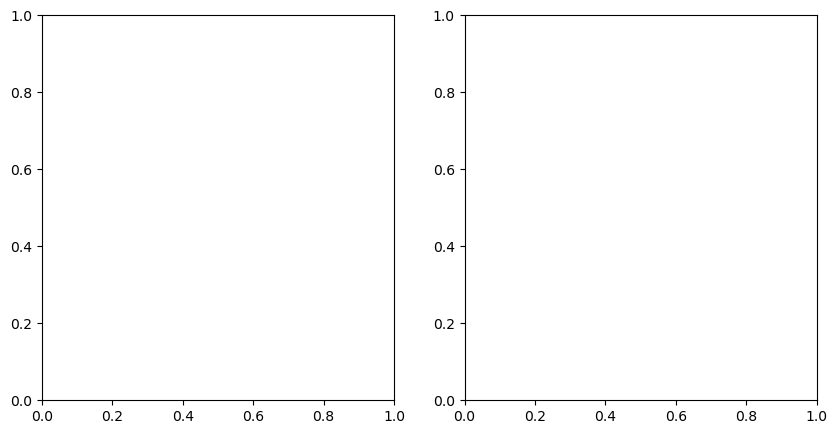

In [33]:
colors=['lightseagreen','firebrick']
labels=['Eulerian','Lagrangian']
fig,axs = plt.subplots(1,2,figsize=(10,5))

for ax in axs:
    np.log10(E.mean('lat_bins')).plot(ax=ax,c=colors[0])
    np.log10(ds['uv'].mean('lat_bins')).plot(ax=ax,c=colors[1])
    
    ax.grid();ax.legend(labels)
axs[1].set_xlim(-5,5)

(-5.0, 5.0)

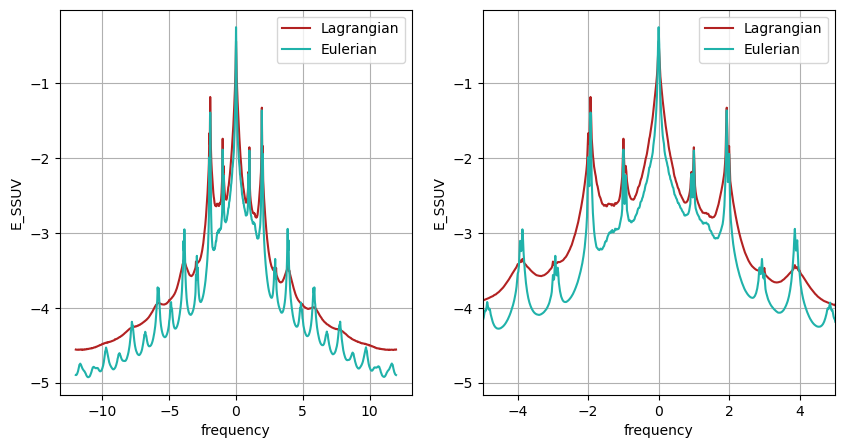

In [71]:
colors=['lightseagreen','firebrick']
labels=['Eulerian','Lagrangian']
fig,axs = plt.subplots(1,2,figsize=(10,5))
for ax in axs:
    np.log10(E_nomean.mean('lat_bins')).plot(ax=ax,c=colors[0])
    np.log10(ds['uv_mean1'].mean('lat_bins')).plot(ax=ax,c=colors[1])
    
    ax.grid();ax.legend(labels)
axs[1].set_xlim(-5,5)

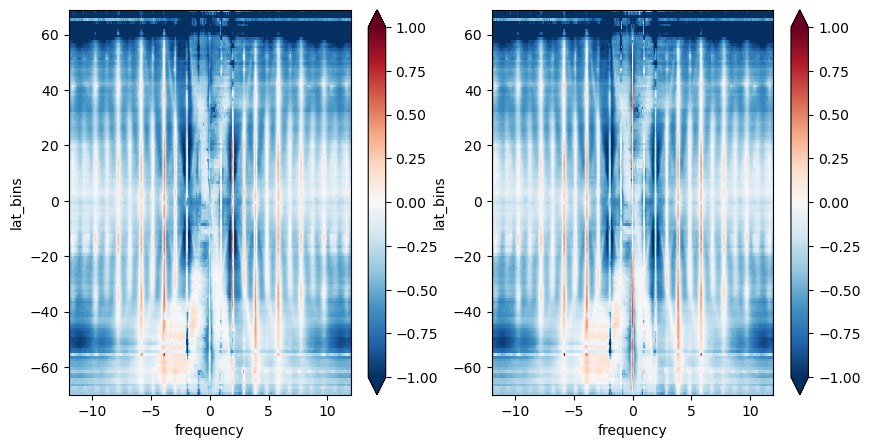

In [73]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(E/ds['uv']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[0],vmax=1)
np.log10(E_nomean/ds['uv_mean1']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[1],vmax=1)

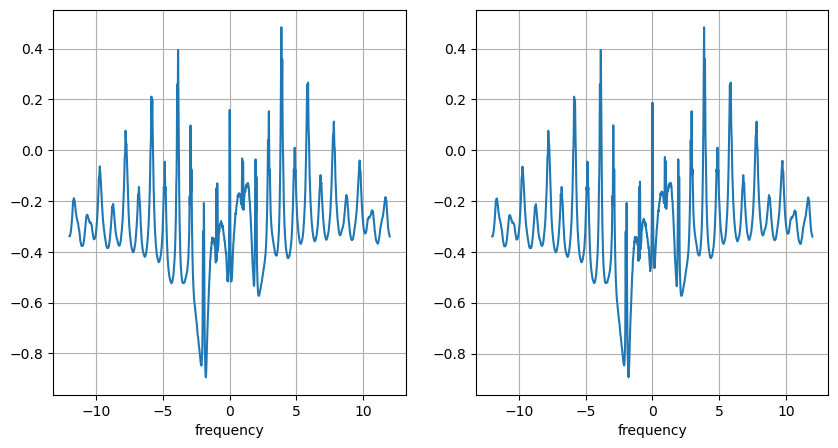

In [75]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(E.mean('lat_bins')/ds['uv'].mean('lat_bins')).plot(ax=ax[0])
np.log10(E_nomean.mean('lat_bins')/ds['uv_mean1'].mean('lat_bins')).plot(ax=ax[1])
for a in ax:
    a.grid()

In [20]:
cluster.close()

distributed.core - ERROR - 'tcp://10.148.0.252:50423'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 573, in handle_stream
    handler(**merge(extra, msg))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 5018, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.148.0.252:50423'
distributed.utils - ERROR - 'tcp://10.148.0.252:50423'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/utils.py", line 668, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 4032, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/sched